### Load Libs

In [22]:
# load packages
import numpy as np 
import scipy.io
from scipy.fft import fft, ifft
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73

In [23]:
# Main Directory of processed file from MatLab
MainDir='D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
SaveFigDir='D:\\AttnXV3_analysis\\F1NRushPlots\\' # set dir where imgs will be saved
os.chdir(MainDir)
# Set File Name 
d=os.listdir(MainDir) # list files in dir
FileN=(d[0]) # choose one
file_path=os.path.join(MainDir, FileN) # join paths and prep 2 load
print(file_path) # does path exist ... ?
print(os.path.exists(file_path)) # yes or no
print(SaveFigDir) 
print(os.path.exists(SaveFigDir))

D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
True
D:\AttnXV3_analysis\F1NRushPlots\
True


In [24]:
NumBins=6 # number of contrasts
NumHarms=2 # number of harmonic data: 2F1, 4F1
NumComp=0 # first component from RCA
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
soi=15 # subjects data to look at 
NumBoots=1000 # number of shuffling arrays we will have and then plot

### Functions

In [25]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
##############################################################################
# shuffle data before real and imaginary numbers are combined
def ShuffleTrials(x, NumComp):
    x = np.array(x) # set data as array
    x = x[:,NumComp,:] # get # component we want
    shuff_data = np.ones_like(x) # copy of 24 x 78
    [NumRows, NumTrials] = x.shape # 24 x 78
    TrialInd = np.array(np.arange(0,NumTrials,1)) # array = len of #Trials
    #index = np.random.shuffle(TrialInd)  # random sampling without replacement - just shuffling 
    index = np.random.randint(0,NumTrials,NumTrials) # index position (# trial) # random sampling with replacement 
    NewTrialList = TrialInd[index] # shuffled pos array
    shuff_data = x[:,NewTrialList] # set rando samp w replacment
    return shuff_data # 24 x 78 array (only want 1st rca component)
################################################################################
# comine real and imaginary numbers after shuffling, only 1st component - For average across pre and post
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin # single array output
#######################################################################################################################
# combine real and imaginary numbers on a trial by trial basis - 2 outputs
def CombineRealImagperTrialBasis(x, NumHarms,NumComp):
    x = x[:,NumComp,:] # 24 x 78
    [NumCols, NumTrials] = np.shape(x) # 24 x 78
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int # 12 
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    AmpPerTrial = np.ones((DomainCutoff, NumTrials)) # 12 x 78
    for trial in range(NumTrials): # combine real and imaginary numbers per trial - non-averaged
        for bin in range(DomainCutoff):
            AmpPerTrial[bin,trial] = np.hypot(x[bin,trial],x[bin+DomainCutoff,trial])
    y = AmpPerTrial[:,:CondCutoff] # 12 x 39 PRE
    z = AmpPerTrial[:,CondCutoff:] # 12  39 POST
    return y,z # returns 2 arrays of bins [2f1/4f1] x half total trials [pre/post]
###########################################################################################################################
def RemoveNaNTrials(x): # remove any trial that has a NaN
    x = np.array(x)
    [freqs, TotTrials] = np.shape(x) # 12 x 38
    d = []
    for trials in range(TotTrials):
        row_check = x[:,trials]
        nan_count = sum(np.isnan( x[:,trials]))
        if nan_count == 0:
            d.append(row_check)
        #else:
        #    print(f'will remove trial {trials}')
    NewArray = np.array(d)
    [a,GoodTrials] = np.shape(NewArray)
    #TrialsRemaining = TotTrials - GoodTrials
    return NewArray#, TrialsRemaining # return array of good trials how many trials we have left out of 39/40
############ Naka-Rushton function: Response as function of luminance contrast #########################################
#    return Rmax * (c**n) / (c**n + c50**n)
## R(C) = Rmax * C^n / ((C^n)underscore50 + C^n) - 3 PARAMETERS
# 1.) Rmax = maximum response (amplitude of VEP)/ spike rate at which the response saturates
# 2.) C50 = contrast necessary to reach 50% of the maximum response (semisaturation contrast) 
# 3.) n = determines the slope of the curve as well as sharpness of of the nonlinearities at low and high contrasts
## n is determined through an iterative fitting process - try least squares fitting

### Step 0: Load Data

In [26]:
mat_data = scipy.io.loadmat(file_path)
rca = mat_data['rcaResult']['projectedData'][0,0]
rcaData = [rca[i,0] for i in range(rca.shape[0])] # final data output

### Step 1: Replace 0's in data with NaN's

In [27]:
rca = dict()
for k in range(len(rcaData)):
    rca[k] = CleanRCA(rcaData[k])
print(rca[0].shape) # 24 x 4 x 78

(24, 4, 78)


### Step 2: Combine Real and Imaginary Components of RCA Per Trials

In [28]:
pre , post = CombineRealImagperTrialBasis(rca[soi], NumHarms, NumComp) # 12 x 39, #preClean = RemoveNaNTrials(pre) - can remove nan's

### ... and find average CRF across all Trials

In [29]:
d = rca[soi][:,NumComp,:]
avgCRF = CombineRealImg(d, NumHarms)
print(avgCRF.shape) # 12 x 2 ||||   #avgCRF[:,0] # Pre [0:6,0] 2f1, [6:,0] 4f1 \\\ avgCRF[:,1] # Post [0:6,0] 2f1, [6:,0] 4f1

(12, 2)


### Step 2.5: Segment Data Properly B4 We Feed Data into Scipy.curve_fit

In [30]:
PreActivity = dict() # 6 x 39 each key 2f1 --> 4f1
PostActivity = dict() # 6 x 39 each key

for Harmon in range(NumHarms):
    PreActivity[Harmon] = pre[0+(Harmon*NumBins):6+(Harmon*NumBins),:]
    PostActivity[Harmon] = post[0+(Harmon*NumBins):6+(Harmon*NumBins),:]

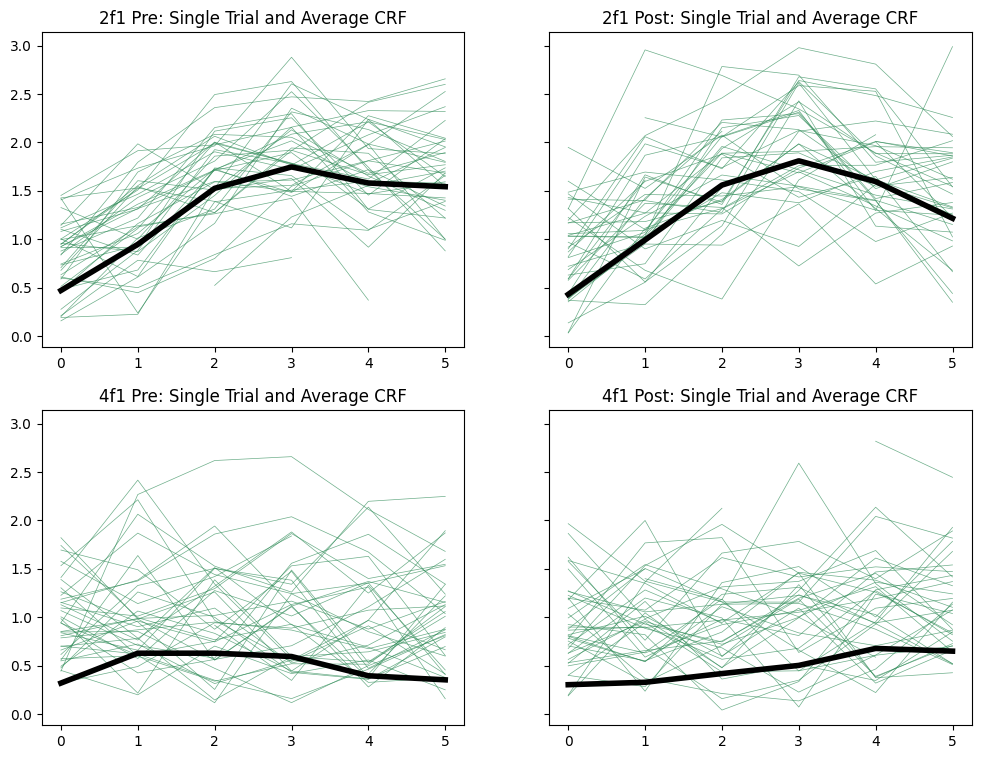

In [52]:
## vis everything to make sure everything looks aight
fig, axs = plt.subplots(2, NumHarms, figsize=(12, 9), sharey = True)

axs[0,0].plot(PreActivity[0], color = (46/255, 139/255, 87/255), linewidth = 1/2, alpha = 0.7)
axs[0,0].set_title('2f1 Pre: Single Trial and Average CRF')
axs[0,0].plot(avgCRF[0:6,0], linewidth = 4, color = 'black')

axs[0,1].plot(PostActivity[0], color = (46/255, 139/255, 87/255), linewidth = 1/2, alpha = 0.7)
axs[0,1].set_title('2f1 Post: Single Trial and Average CRF')
axs[0,1].plot(avgCRF[0:6,1], linewidth = 4, color = 'black')

axs[1,0].plot(PreActivity[1], color = (46/255, 139/255, 87/255), linewidth = 1/2, alpha = 0.7)
axs[1,0].set_title('4f1 Pre: Single Trial and Average CRF')
axs[1,0].plot(avgCRF[6:,0], linewidth = 4, color = 'black')

axs[1,1].plot(PostActivity[1], color = (46/255, 139/255, 87/255), linewidth = 1/2, alpha = 0.7)
axs[1,1].set_title('4f1 Post: Single Trial and Average CRF')
axs[1,1].plot(avgCRF[6:,1], linewidth = 4, color = 'black')
plt.show()

### Step 3: Set Parameters & Boundaries for Scipy Optimize Curve Fit

In [32]:
# function to model curve
def naka_rushton(C, C50, n, Rmax, b):
    return ((Rmax * ((C**n) / (C50**n + C**n)))+b)

##### Define Initial Guesses for the Parameters

In [53]:
### Model Estimates,,, based on nothing soild - subject to change 
boundaries=([3,0.25,0.5,0], [60,5,10,5]) # Boundary Params for C50, N, Rmax and B
param_names=['C50','n','Rmax','b']
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
[NumBins, NumTrials]=PreActivity[0].shape # Data Dims

## Step 4: Perform Naka Rushton Computations On Pre and Post Data 

In [54]:
PreParams = np.zeros((2,4))

for iters in range(len(PreActivity.keys())):
    initial_guesses = [40,3,8,0.3] # reset guesses to default after each curve fit for harmonic data
    pre_optim = [] # reset params stored ... ^^^
    for t in range(NumTrials):
        # Fit the Naka-Rushton function to the data
        pre_popt, pre_pcov = curve_fit(naka_rushton, contrast_levels, PreActivity[iters][:,t], p0=initial_guesses, bounds = boundaries, nan_policy='omit')
        pre_optim.append(pre_popt)
        initial_guesses = pre_popt

    params_saved = np.array(pre_optim)
    print(params_saved.shape) # make sure data shape is equal to number of trials
    # average all param values across trials      
    Avg_popt = np.mean(params_saved, axis = 0) # average across all trial parameters estimated
    print(Avg_popt) # averaged parameters in model
    PreParams[iters,:] = Avg_popt


    # try fitting naka rushton along averaged data

(39, 4)
[6.04299984 4.09975354 1.1050755  0.76664481]
(39, 4)
[27.05392548  2.44550892  0.66088242  0.67605873]


In [55]:
PostParams = np.zeros((2,4))

for iters in range(len(PostActivity.keys())):
    initial_guesses = [40,3,8,1] # reset guesses to default after each curve fit for harmonic data
    post_optim = [] # reset params stored ... ^^^
    for t in range(NumTrials):
        # Fit the Naka-Rushton function to the data
        post_popt, pre_pcov = curve_fit(naka_rushton, contrast_levels, PostActivity[iters][:,t], p0=initial_guesses, bounds = boundaries, nan_policy='omit')
        post_optim.append(post_popt)
        initial_guesses = post_popt

    params_saved = np.array(post_optim)
    print(params_saved.shape) # make sure data shape is equal to number of trials
    # average all param values across trials      
    Avg_popt = np.mean(params_saved, axis = 0) # average across all trial parameters estimated
    print(Avg_popt) # averaged parameters in model
    PostParams[iters,:] = Avg_popt

(39, 4)
[7.13432808 4.31418074 1.04425659 0.81809822]
(39, 4)
[30.82191569  2.4007752   0.73983037  0.70599285]


#### Visual of Naka Rushton Model on Single and Average CRF's per Condition

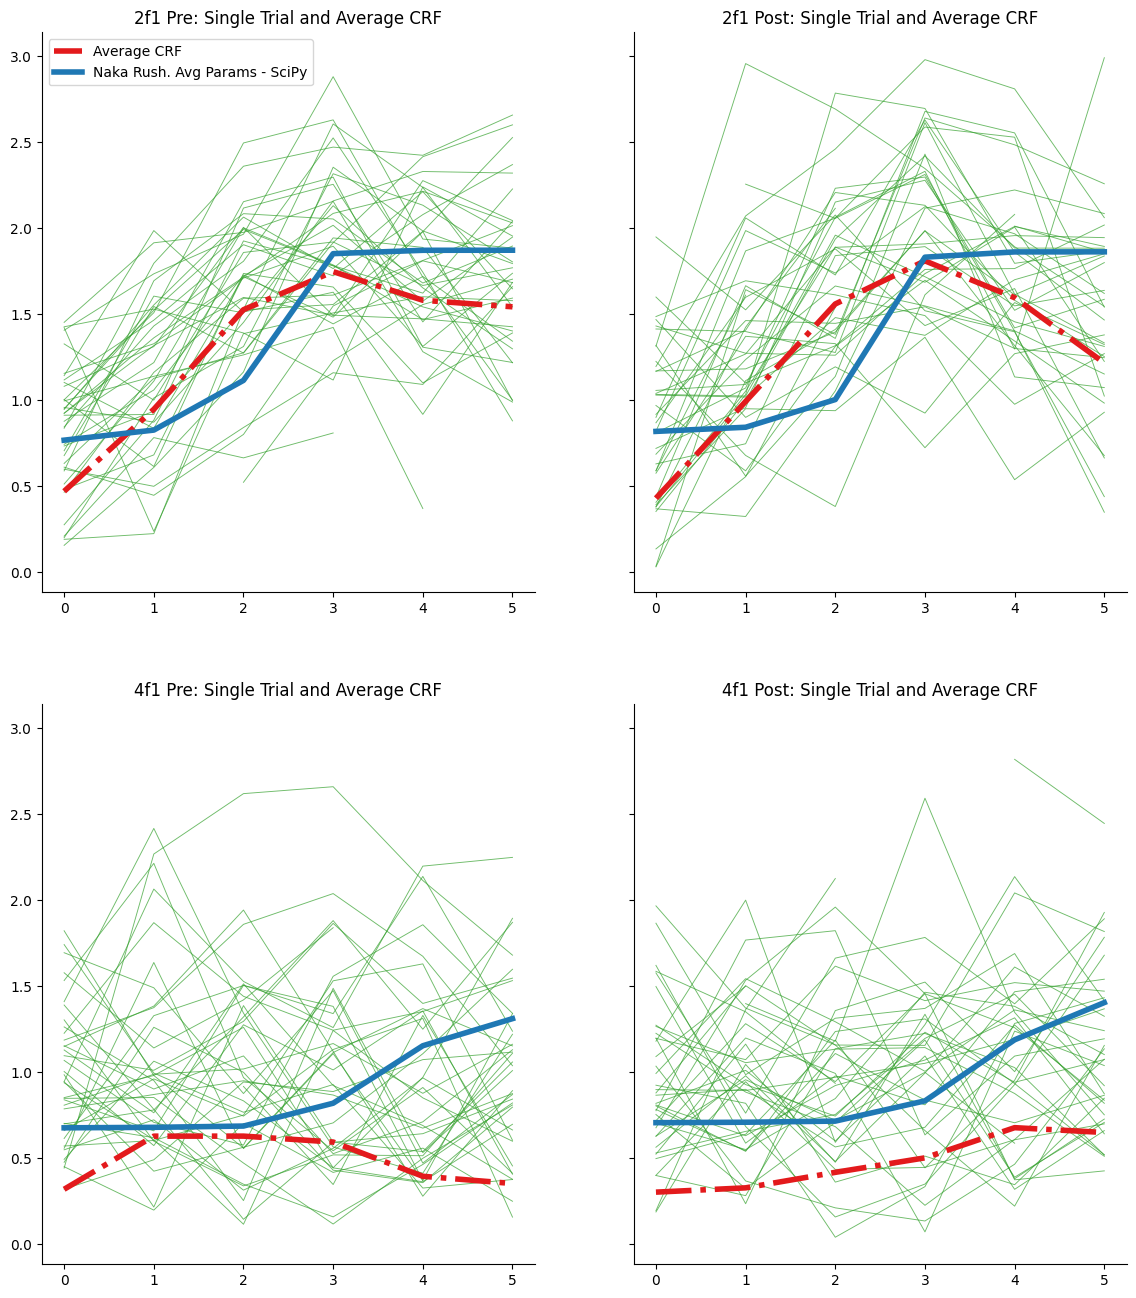

In [56]:
x  = sns.color_palette("Paired",12) # sns.color_palette("Paired",12)
## vis everything to make sure everything looks aight
fig, axs = plt.subplots(2, NumHarms, figsize=(14,16), sharey = True)

axs[0,0].plot(PreActivity[0], color = x[3], linewidth = 2/3, alpha = 0.7)
axs[0,0].set_title('2f1 Pre: Single Trial and Average CRF')
axs[0,0].plot(avgCRF[0:6,0], linewidth = 4,linestyle = '-.', color = x[5], label = 'Average CRF')
axs[0,0].plot(naka_rushton(contrast_levels, PreParams[0,0] , PreParams[0,1]  ,PreParams[0,2] , PreParams[0,3]), linewidth = 4, color =  x[1], label = 'Naka Rush. Avg Params - SciPy')
axs[0,0].legend(fontsize = 10, loc = 'upper left')
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
#axs[0,0].grid(True)

axs[0,1].plot(PostActivity[0], color =x[3], linewidth = 2/3, alpha = 0.7)
axs[0,1].set_title('2f1 Post: Single Trial and Average CRF')
axs[0,1].plot(avgCRF[0:6,1], linewidth = 4,linestyle = '-.', color = x[5])
axs[0,1].plot(naka_rushton(contrast_levels, PostParams[0,0] , PostParams[0,1]  ,PostParams[0,2] , PostParams[0,3]), linewidth = 4, color = x[1], label = 'Naka Rush. Avg Params - SciPy')
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
#axs[0,1].grid(True)

axs[1,0].plot(PreActivity[1], color = x[3], linewidth = 2/3, alpha = 0.7)
axs[1,0].set_title('4f1 Pre: Single Trial and Average CRF')
axs[1,0].plot(avgCRF[6:,0], linewidth = 4,linestyle = '-.', color = x[5])
axs[1,0].plot(naka_rushton(contrast_levels, PreParams[1,0] , PreParams[1,1]  ,PreParams[1,2] , PreParams[1,3]), linewidth = 4, color = x[1], label = 'Naka Rush. Avg Params - SciPy')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
#axs[1,0].grid(True)

axs[1,1].plot(PostActivity[1], color = x[3], linewidth = 2/3, alpha = 0.7)
axs[1,1].set_title('4f1 Post: Single Trial and Average CRF')
axs[1,1].plot(avgCRF[6:,1], linewidth = 4,linestyle = '-.', color = x[5])
axs[1,1].plot(naka_rushton(contrast_levels, PostParams[1,0] , PostParams[1,1]  ,PostParams[1,2] , PostParams[1,3]), linewidth = 4, color = x[1], label = 'Naka Rush. Avg Params - SciPy')
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
#axs[1,1].grid(True)
plt.show()

#### Covariance Matrix - doesnt work anymore

In [ ]:
#plt.figure(figsize=(5,5))
#sns.heatmap(pcov, annot=True, cmap='coolwarm', fmt=".0f", linewidths=1)
#plt.title('Covariance Matrix')
#plt.xlabel('Parameters')
#plt.ylabel('Parameters')
#plt.xticks(ticks=np.arange(len(param_names)) + 0.5, labels=param_names)
#plt.yticks(ticks=np.arange(len(param_names)) + 0.5, labels=param_names)
#plt.show()
#print(pcov)


#### Run model on averaged data

[3.         5.         1.13507642 0.42874296]


[]

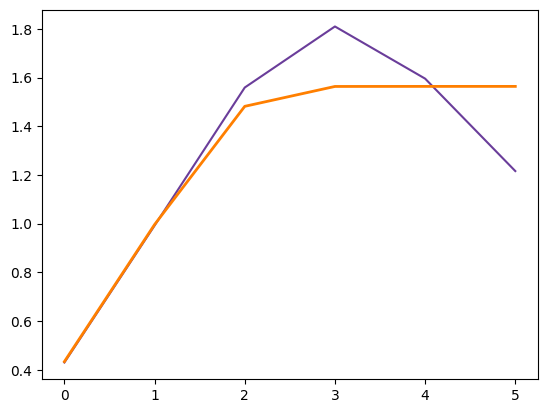

In [61]:
pre2f = avgCRF[0:6,1]
initial_guesses = [40,3,10,0.2] # reset guesses to default after each curve fit for harmonic data

# Fit the Naka-Rushton function to the data
pre_popt, pre_pcov = curve_fit(naka_rushton, contrast_levels, pre2f, p0=initial_guesses, bounds = boundaries, nan_policy='omit')
#pre_optim.append(pre_popt)
#initial_guesses = pre_popt
print(pre_popt)

plt.plot(pre2f, color = x[9])
plt.plot(naka_rushton(contrast_levels, pre_popt[0] , pre_popt[1]  ,pre_popt[2] , pre_popt[3]), linewidth = 2, color = x[7], label = 'Naka Rush. Avg Params - SciPy')
plt.plot()

In [ ]:
plt.plot(pre2f, color = x[9])
plt.plot(naka_rushton(contrast_levels, 3 , 5  ,2 , 0.37), linewidth = 4, color = x[7], label = 'Naka Rush. Avg Params - SciPy')
plt.plot()